# Fitting multi-moal empirical data

Fitting multi modal data to known distributions use is done using [Chi2Fit](https://hex.pm/packages/chi2fit).

The source of the data used is a LinkedIn post [5].

## Table of contents

* [Set-up](#Set-up)
* [Data and simulation set-up](#Data-and-simulation-set-up)
* [Preparation](#Preparation)
* [Fitting the data to a Weibull distribution](#Fitting-the-data-to-a-Weibull-distribution)
* [Mixture: bimodal fit](#Mixture:-bimodal-fit)
* [Mixture: Trimodal fit](#Mixture:-Trimodal-fit)
* [References](#References)

## Set-up

In [1]:
alias Chi2fit.Distribution, as: D
alias Chi2fit.Fit, as: F
alias Chi2fit.Matrix, as: M
alias Chi2fit.Utilities, as: U
alias Gnuplotlib, as: P
alias Exboost.Math

Exboost.Math

## Data and simulation set-up

As an example consider the lead time of work items.

In [2]:
data = [{2,30},{4,20},{6,50},{8,35},{10,27},{12,11},{14,20},{16,16},{18,2}]
|> Enum.map(fn {x,count}->List.duplicate(x,count) end)
|> Enum.concat

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...]

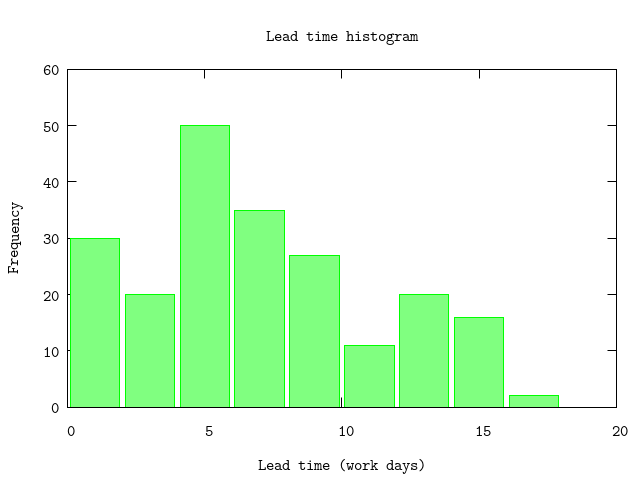

In [3]:
P.histogram(data|>Enum.map(&(&1-2)),
    plottitle: "Lead time histogram",
    xlabel: "Lead time (work days)",
    ylabel: "Frequency",
    yrange: '[0:60]',
    xrange: '[0:20]',
    bin: 2)
:"this is an inline image"

Other parameters that affect the forecasting are listed below. Please adjust to your needs.

In [4]:
# The size of the backlog, e.g. 100 backlog items
size = 100

# Number of iterations to use in the Monte Carlo
iterations = 1000

# The size of bins for grouping the data
binsize = 2

# Number of probes to use in the chi2 fit
probes = 10_000

# The range of the parameter to look for a (global) minimum
initial = [{0.1,100},{0.1,100}]

[{0.1, 100}, {0.1, 100}]

## Preparation

Next, we convert the throughput data to a histogram. To this end we group the data in bins of size 1 starting at 0.

In [5]:
hdata = U.to_bins data, {binsize,0}

[{2, 0.14218009478672985, 0.11763126086189865, 0.1704357123311724}, {4, 0.23696682464454977, 0.20671909500659005, 0.2698962200083305}, {6, 0.47393364928909953, 0.43741329018521213, 0.5107168295382927}, {8, 0.6398104265402843, 0.6037687948186518, 0.6744387590292628}, {10, 0.7677725118483413, 0.7350209817990428, 0.7977926342682362}, {12, 0.8199052132701422, 0.7894693135637256, 0.8470538678739661}, {14, 0.9146919431279621, 0.8908556876600358, 0.9341374988763276}, {16, 0.990521327014218, 0.9780690698488889, 0.9967869767458777}, {18, 1.0, 0.9912012213721544, 1.0}]

The data returned contains a list of tuples each describing a bin:
* the end-point of the bin,
* the proportional number of events for this bin (the total count is normalized to one),
* the lower value of the error bound,
* the upper value of the error bound.

As can be seen the sizes of the lower and upper bounds are different in value, i.e. they are asymmetrical. The contribution or weight to the likelihood function used in fitting known distributions will de different depending on whether the observed value if larger or smaller than the predicted value. This is specified by using the option `:linear` (see below). See [3] for details.

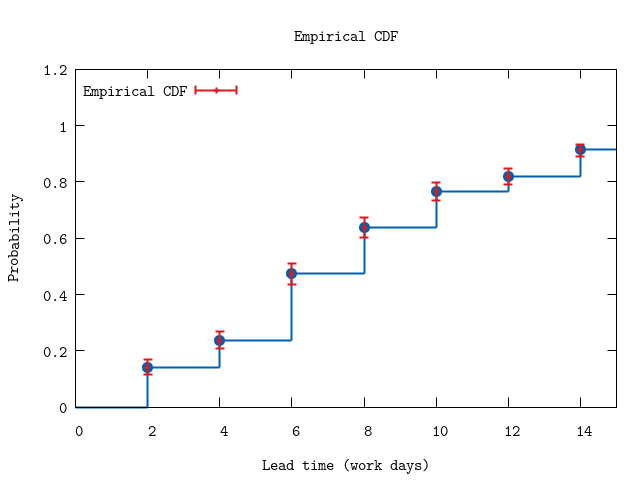

In [6]:
P.ecdf(hdata,
    plottitle: "Empirical CDF",
    xlabel: "Lead time (work days)",
    ylabel: "Probability",
    xrange: '[0:15]')
:"this is an inline image"

## Fitting the data to a Weibull distribution

The code below uses basic settings of the commands provided by `Chi2Fit`. More advanced options can be found at [2]. First a fixed number of random parameter values are tried to get a rough estimate. The option `probes` equals the number of tries. Furthermore, since we are fitting a probability distribution which has values on the interval `[0,1]` the errors are asymmetrical. This is specified by the option `linear`. 

In [20]:
# Start the collector to capture the xyz data
{:ok, pid} = U.Collector.start_link
U.Collector.collect()

model = D.model "weibull"
options = [probes: 100_000, smoothing: false, model: :linear, saved?: true, surfacefile: pid]
initial = [{0.1,1.5},{7.5,8.5}]
result = {_,parameters,_,saved} = F.chi2probe hdata, initial, {Distribution.cdf(model), &F.nopenalties/2}, options

xyz = U.Collector.value()
U.Collector.stop()

U.display result

Initial guess:
    chi2:		30.120009955542805
    pars:		[1.4997620999513008, 7.564321644024582]
    ranges:		{[1.4913607013045735, 1.49997771470341], [7.504099984490524, 7.695921113569285]}



:ok

The errors reported is the found range of parameter values where the corresponding `chi2` values are within 1 of the found minimum value.

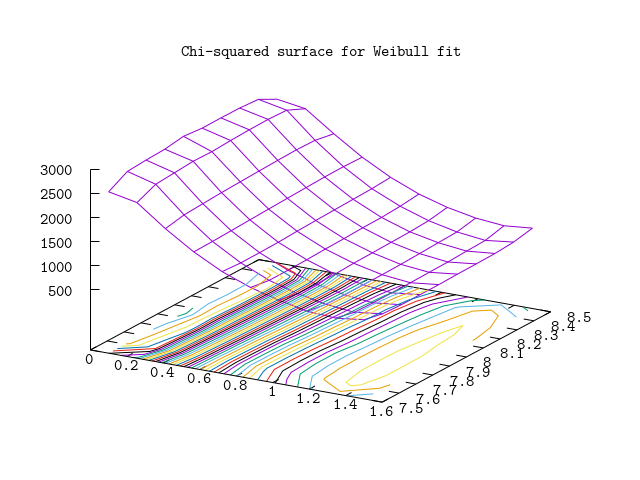

In [22]:
xyz
|> Enum.map(&(&1|>String.replace("\n","")|>String.split(","))|>Enum.map(fn str -> Float.parse(str)|>elem(0) end))
|> P.surface(
  plottitle: "Chi-squared surface for Weibull fit")
:"this is an inline image"

After roughly locating the minimum we do a more precise (and computationally more expensive) search for the minimum.

In [15]:
options = [{:probes,saved}|options]
result = {_,cov,parameters,_} = F.chi2fit hdata, {parameters, Distribution.cdf(model), &F.nopenalties/2}, 20, options
U.display(hdata,model,result,options)

Final:
    chi2:		21.016205152146497
    Degrees of freedom:	7
    gradient:		[7.359475153013114e-8, -1.323579173501725e-7]
    parameters:		[1.6636188028655563, 7.824038073291134]
    errors:		[0.05415224437889227, 0.15315595906602308]
    ranges:
			chi2:		21.016205152146497	-	21.62408077717052
			parameter:	1.6636188027153607	-	1.6817854944627586
			parameter:	7.755024596279445	-	7.824038076102025


:ok

The gradient indicates that we are at the (local) minimum. The chi-squared statistic is about 3 per degree of freedom which is not a particular good fit. This means that a Weibull is unlikely to be the 'real' underlying probability distribution.

The covariance matrix shows that the parameters are uncorrelated:

In [16]:
cov|>Enum.each(& IO.puts "[#{Enum.join(&1,",")}]\n")

[0.0029324655712712694,0.003907034785710852]

[0.003907034785710852,0.02345674779743334]



:ok

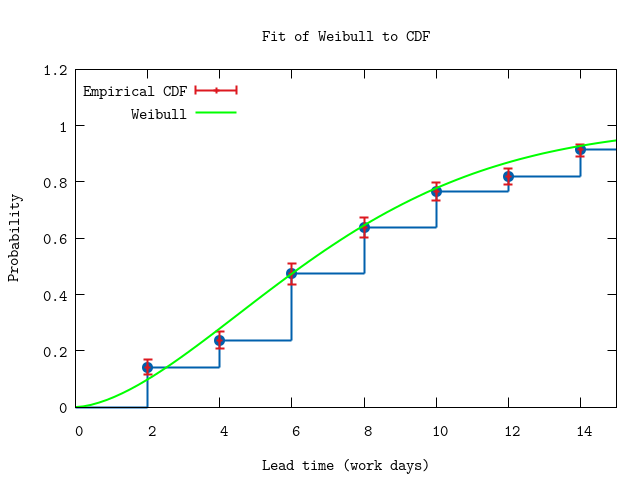

In [17]:
P.ecdf(hdata,
    plottitle: "Fit of Weibull to CDF",
    xlabel: "Lead time (work days)",
    ylabel: "Probability",
    xrange: '[0:15]',
    title: "Weibull",
    func: & Distribution.cdf(model).(&1,parameters))
:"this is an inline image"

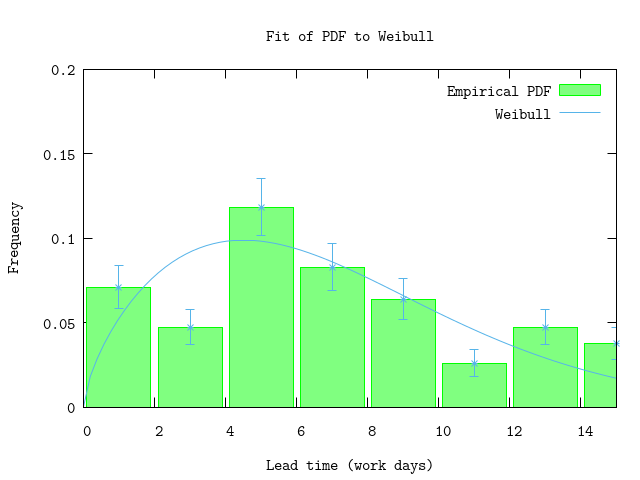

In [18]:
pdf = fn x -> Distribution.pdf(model).(x,parameters) end
P.pdf(data|>Enum.map(&(&1-2)),
    plottitle: "Fit of PDF to Weibull",
    xlabel: "Lead time (work days)",
    ylabel: "Frequency",
    yrange: '[0:0.20]',
    xrange: '[0:15]',
    pdf: pdf,
    bin: 2,
    title: "Weibull")
:"this is an inline image"

## Mixture: bimodal fit

The dip in the histogram suggest we are dealing with two different work item types. Therefore, we try a combination of two Weibull distributions.

In [19]:
model = %Distribution.BiModal{distribs: [%Distribution.Weibull{},%Distribution.Weibull{}]}
initial = [{0,1},{0.1,10},{0.1,10},{0.1,10},{0.1,10}]
options = [probes: 100_000, smoothing: false, model: :linear, saved?: true]
result = {_,parameters2,_,saved} = F.chi2probe hdata, initial, {Distribution.cdf(model), &F.nopenalties/2}, options
U.display result

Initial guess:
    chi2:		12.397355309091466
    pars:		[0.8762009097372363, 2.1426248215381074, 8.976462658934922, 5.786703467934153, 1.5176517391957534]
    ranges:		{[0.5220312781591963, 0.8762009097372363], [1.3169145827835502, 2.18237523702557], [5.693992582369576, 9.01689219790285], [2.639060289256899, 5.786703467934153], [1.0562086729685385, 9.94239004251748]}



:ok

In [20]:
options = [{:probes,saved}|options]
result = {_,cov,parameters2,_} = F.chi2fit hdata, {parameters2, Distribution.cdf(model), &F.nopenalties/2}, 40, options
U.display(hdata,model,result,options)

Final:
    chi2:		11.765943487179154
    Degrees of freedom:	4
    gradient:		[-1.1293629946390302e-5, 9.76761222975458e-7, -1.6287532213024378e-6, -1.127773430198431e-10, 1.6152625903487206e-9]
    parameters:		[0.9031769771553447, 2.02657360047218, 8.734126695845797, 7.782928027592084, 1.3322373474189828]
    errors:		[0.02009486950443007, 0.07789075914365685, 7.491055121363457e-47, 4986716251.585587, 56.70581287512329]
    ranges:
			chi2:		11.765943487179154	-	12.712190185556427
			parameter:	0.8762009097372363	-	0.9119714506903362
			parameter:	1.9556127581409364	-	2.1426248215381074
			parameter:	8.575628824596247	-	8.976462658934922
			parameter:	0.8478984173542692	-	7.783542984979537
			parameter:	1.3322114588459644	-	1.5989791696119213


:ok

The result is similar to the previous section: a chi-squared statistic of about 3 per degree of freedom.

The covariance matrix is:

In [23]:
cov|>Enum.each(& IO.puts "[#{&1|>Enum.map(fn x->Float.round(x,6) end)|>Enum.join(",")}]\n")

[4.04e-4,-2.95e-4,0.0,156701356.731678,6.72e-4]

[-2.95e-4,0.006067,0.0,-629791265.80801,-0.013853]

[0.0,0.0,0.0,-1636178017.523809,0.0]

[156701356.731678,-629791265.80801,-1636178017.523809,-2.4867338973827805e19,2409903565.907655]

[6.72e-4,-0.013853,0.0,2409903565.907654,3215.549214]



:ok

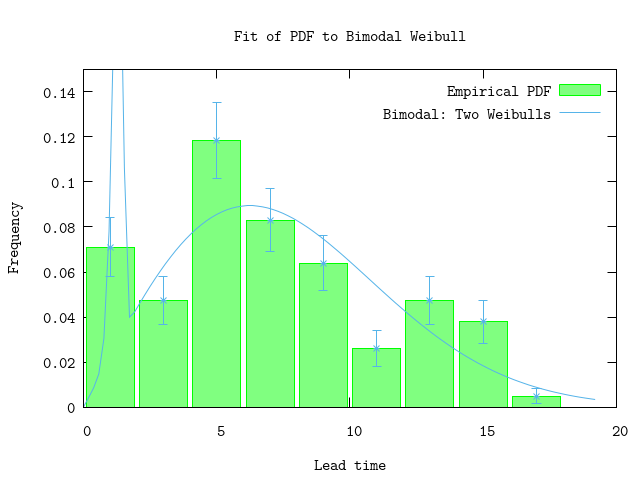

In [24]:
pdf = fn x -> Distribution.pdf(model).(x,parameters2) end
P.pdf(data|>Enum.map(&(&1-2)),
    plottitle: "Fit of PDF to Bimodal Weibull",
    xlabel: "Lead time",
    ylabel: "Frequency",
    xrange: '[0:20]',
    yrange: '[0:0.15]',
    pdf: pdf,
    bin: 2,
    title: "Bimodal: Two Weibulls")
:"this is an inline image"

## Mixture: Trimodal fit

Next, we try a combination of three Weibulls to accomodate for the two gaps in the histogram.

In [25]:
model = %Distribution.TriModal{distribs: List.duplicate(%Distribution.Weibull{},3)}
initial = [{0,1},{0,1},{0.5,5.0},{0.5,5.0},{0.5,5.0},{0.5,5.0},{0.5,5.0},{0.5,5.0}]
options = [probes: 1_000_000, smoothing: false, model: :linear, saved?: true]
result = {_,parameters3,_,saved} = F.chi2probe hdata, initial, {Distribution.cdf(model), &F.nopenalties/2}, options
U.display result

Initial guess:
    chi2:		544.9884254804533
    pars:		[0.9994299671110422, 0.5037882391211317, 0.9932601609176348, 4.976746733138928, 2.0919204174433297, 1.182671204718735, 3.5391186360458016, 1.8852414620289066]
    ranges:		{[0.9994299671110422, 0.9994299671110422], [0.5037882391211317, 0.5037882391211317], [0.9932601609176348, 0.9932601609176348], [4.976746733138928, 4.976746733138928], [2.0919204174433297, 2.0919204174433297], [1.182671204718735, 1.182671204718735], [3.5391186360458016, 3.5391186360458016], [1.8852414620289066, 1.8852414620289066]}



:ok

In [26]:
options = [smoothing: false, model: :linear, saved?: true, probes: saved]

[smoothing: false, model: :linear, saved?: true, probes: [{544.9884254804533, [0.9994299671110422, 0.5037882391211317, 0.9932601609176348, 4.976746733138928, 2.0919204174433297, 1.182671204718735, 3.5391186360458016, 1.8852414620289066]}]]

In [27]:
result = {_,cov,parameters3,_} = F.chi2fit hdata, {parameters3, Distribution.cdf(model), &F.nopenalties/2}, 120, options
U.display(hdata,model,result,options)

Final:
    chi2:		2.719614763849111
    Degrees of freedom:	1
    gradient:		[-155.55105004425442, 0.0013887378752578962, -0.23761524555679392, 0.06682855282051255, -4.2948178901269785e-5, 0.023872780016965887, -1.5958059256073777e-9, -9.697826044430258e-8]
    parameters:		[1.000689266556855, -81.17856102734184, 1.4381956351151717, 7.911361463270546, 31.08055707256469, 5.948439495814306, 58.446373310281544, 2.8146128328949827]
    errors:		[0.0037217394915818095, 418.31806573482623, 0.09639720869153207, 0.22502579427154798, 596.1700157134271, 1.0204674316603946, 4110.888349319595, 858.0621923335698]
    ranges:
			chi2:		2.719614763849111	-	3.7180438513491847
			parameter:	1.0004907163964438	-	1.005486561574827
			parameter:	-112.97099350407899	-	-7.597816556253781
			parameter:	1.4277467955225163	-	1.4917875309426627
			parameter:	7.862554491596877	-	7.991800479630337
			parameter:	1.8987198528623295	-	74.7419940861542
			parameter:	4.50252402411369	-	7.429471563936467
			parameter:	

:ok

The covariance matrix is:

In [28]:
cov|>Enum.each(& IO.puts "[#{&1|>Enum.map(fn x->Float.round(x,3) end)|>Enum.join(",")}]\n")

[0.0,1.555,0.0,0.0,0.008,0.0,0.0,0.001]

[1.555,174990.004,2.284,-1.391,868.976,-2.621,-62.214,103.087]

[0.0,2.284,0.009,0.007,2.193,-0.007,0.333,-0.004]

[0.0,-1.391,0.007,0.051,8.312,-0.025,2.376,-0.036]

[0.008,868.976,2.193,8.312,355418.688,552.814,390.299,-5.39]

[0.0,-2.621,-0.007,-0.025,552.814,1.041,-1.197,0.017]

[0.0,-62.214,0.333,2.376,390.299,-1.197,16899403.021,-254777.107]

[0.001,103.087,-0.004,-0.036,-5.39,0.017,-254777.107,736270.726]



:ok

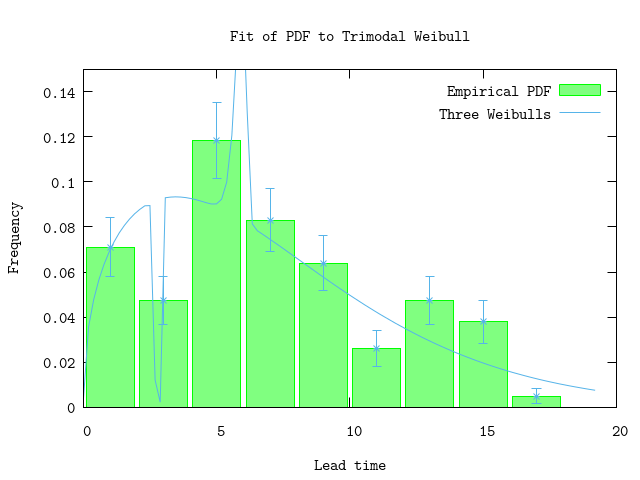

In [29]:
model = %Distribution.TriModal{distribs: List.duplicate(%Distribution.Weibull{},3)}
pdf = fn x -> Distribution.pdf(model).(x+0.001,parameters3) end
P.pdf(data|>Enum.map(&(&1-2)),
    plottitle: "Fit of PDF to Trimodal Weibull",
    xlabel: "Lead time",
    ylabel: "Frequency",
    xrange: '[0:20]',
    yrange: '[0:0.15]',
    pdf: pdf,
    bin: 2,
    title: "Three Weibulls")
:"this is an inline image"

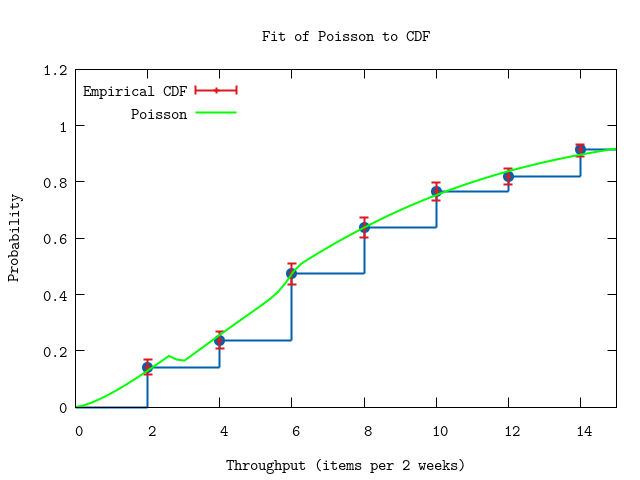

In [30]:
P.ecdf(hdata,
    plottitle: "Fit of Poisson to CDF",
    xlabel: "Throughput (items per 2 weeks)",
    ylabel: "Probability",
    xrange: '[0:15]',
    title: "Poisson",
    func: & Distribution.cdf(model).(&1,parameters3))
:"this is an inline image"

## References

[1] _Poisson distribution_, https://en.wikipedia.org/wiki/Poisson_distribution/<br>
[2] _Chi2Fit_, Pieter Rijken, 2018, https://hex.pm/packages/chi2fit<br>
[3] _Asymmetric errors_, Roger Barlow, Manchester University, UK and Stanford University, USA, PHYSTAT2003, SLAC, Stanford, California, September 8-11, 2003, https://www.slac.stanford.edu/econf/C030908/papers/WEMT002.pdf<br>
[4] _Efficient use of Monte Carlo: uncertainty propagation_, D. Rochman et. al., Nuclear Science and Engineering, 2013, ftp://ftp.nrg.eu/pub/www/talys/bib_rochman/fastTMC.pdf<br>
[5] Niladri Bose, LinkedIn post, August 2020